# Calcul du tenseur d'Eshelby dans le cas des ellipses

## 0 Quelques fonctions utiles

In [1]:
from Classes_Ellipsoidales import *     

## MODELE AUTOCOHERENT UNE FORME D'INCLUSION

In [6]:
from scipy.spatial.transform import Rotation as Rot
import time as tm
        
def compute_h_behavior(A,f):
    
    n_renforts = 500     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 80            # pas du modèle autocohérent
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0.3
    Ef = 100
    nuf = 0.3
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Création des matrices de rotations
    MRot = Matrices_rotation(n_renforts)
    
    # Création des liste de résultat
    listF,listE,listNu = [],[],[]
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_pas+1) :
        t_pas = tm.time()
        f_pas = f*i/n_pas
        f_1_renfort = f_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print("******************")
        print('f_pas : ',f_pas)
        #print('        convergence',convergence)
        while convergence>precision :   
            t_point_fixe = tm.time()
            W = np.zeros((6,6)) # Matrice des contributions de l'inclusion dans Ch
            Esh = Eshelby_tensor(A,Eh,nuh)
            Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
            V6 = np.dot(Cf-Cm,Aesh)
            V3 = Comp66_to_3333(V6)
            print("t_esh : ",tm.time()-t_point_fixe)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            t_renfort = tm.time()
            for i in range(n_renforts) : 
                #theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                V3R = Rotation_tenseur(V3,MRot,i)
                V = Comp3333_to_66(V3R)
                W += f_1_renfort * V
            print('t_renfort : ', tm.time()-t_renfort)

            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)/Eh + abs(nu-nuh)/nuh
            #print('        convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            print("temps du point fixe : ",tm.time()-t_point_fixe)
        print('Eh = ',Eh)
        print('nuh = ',nuh)
        listF.append(f_pas)
        listE.append(Eh)
        listNu.append(nuh)
        print("Temps du pas : ",tm.time()-t_pas)
    print("Ch")
    print(Cp)
    return listF,listE,listNu

def compute_h_behavior2(A,f):
    
    n_renforts = 500     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 20            # pas du modèle autocohérent
    precision = 10**-1  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0.3
    Ef = 100
    nuf = 0.3
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Création des matrices de rotations et de la matrice de mémoire pour le calcul presque en place
    Rotation_Op = Rotation_operator(n_renforts)
    B = np.zeros((3,3,3,3))

    
    # Création des liste de résultat
    listF,listE,listNu = [],[],[]
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_pas+1) :
        t_pas = tm.time()
        f_pas = f*i/n_pas
        f_1_renfort = f_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print("******************")
        print('f_pas : ',f_pas)
        #print('        convergence',convergence)
        while convergence>precision :   
            t_point_fixe = tm.time()
            W = np.zeros((6,6)) # Matrice des contributions de l'inclusion dans Ch
            Esh = Eshelby_tensor(A,Eh,nuh)
            Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
            V6 = np.dot(Cf-Cm,Aesh)
            V3 = Comp66_to_3333(V6)
            print("t_esh : ",tm.time()-t_point_fixe)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            t_renfort = tm.time()
            for i in range(n_renforts) : 
                #theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                V3R = Rotation_tenseur3(V3,Rotation_Op,i,B)
                V = Comp3333_to_66(V3R)
                W += f_1_renfort * V
            print('t_renfort : ', tm.time()-t_renfort)
            t_inversion = tm.time()
            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)/Eh + abs(nu-nuh)/nuh
            #print('        convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            print("temps de l'actualisation et des inversions : ",tm.time()-t_inversion)
            print("temps du point fixe : ",tm.time()-t_point_fixe)
        print('Eh = ',Eh)
        print('nuh = ',nuh)
        listF.append(f_pas)
        listE.append(Eh)
        listNu.append(nuh)
        print("Temps du pas : ",tm.time()-t_pas)
    print("Ch")
    print(Cp)
    return listF,listE,listNu

In [ ]:
A = (3,2,1)
f = 0.8
print(compute_h_behavior2(A,f))

******************
f_pas :  0.0
t_esh :  2.399008274078369
t_renfort :  3.271462917327881
temps de l'actualisation et des inversions :  0.0001800060272216797
temps du point fixe :  5.671508073806763
Eh =  1.0
nuh =  0.29999999999999993
Temps du pas :  5.672659873962402
******************
f_pas :  0.04
t_esh :  2.393683671951294
t_renfort :  3.2811520099639893
temps de l'actualisation et des inversions :  0.00019168853759765625
temps du point fixe :  5.675472021102905
t_esh :  2.360260009765625
t_renfort :  3.326951026916504
temps de l'actualisation et des inversions :  0.0001819133758544922
temps du point fixe :  5.688814640045166
Eh =  1.0992034186042654
nuh =  0.2959835888553446
Temps du pas :  11.364580154418945
******************
f_pas :  0.08
t_esh :  2.3532042503356934
t_renfort :  3.3075802326202393
temps de l'actualisation et des inversions :  0.0001804828643798828
temps du point fixe :  5.662484169006348
t_esh :  2.304826498031616
t_renfort :  3.0846199989318848
temps de l'act

## Comparaison avec les spheres isotropes

******************
f_pas :  0.0
t_esh :  2.172518730163574
t_renfort :  5.089391469955444
temps de l'actualisation et des inversions :  0.0001544952392578125
temps du point fixe :  7.2624616622924805
Eh =  1.0000000000000002
nuh =  0.29999999999999993
Temps du pas :  7.263071775436401
******************
f_pas :  0.04
t_esh :  2.1329541206359863
t_renfort :  5.074672222137451
temps de l'actualisation et des inversions :  0.004418849945068359
temps du point fixe :  7.212533235549927
Eh =  1.079765153565042
nuh =  0.29696579980430976
Temps du pas :  7.212784767150879
******************
f_pas :  0.08
t_esh :  2.12813401222229
t_renfort :  5.211488246917725
temps de l'actualisation et des inversions :  0.00018310546875
temps du point fixe :  7.3403050899505615
Eh =  1.1719625203318895
nuh =  0.293703065207487
Temps du pas :  7.3434975147247314
******************
f_pas :  0.12000000000000002
t_esh :  2.1682193279266357
t_renfort :  5.055049896240234
temps de l'actualisation et des inversions

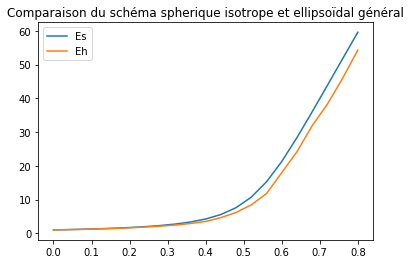

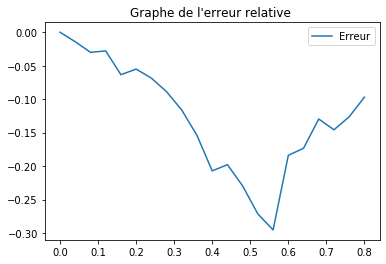

In [10]:
from classes_v2 import * 
fmax = 0.8
A = (1,1,1)
F,Eh,Nuh = compute_h_behavior2(A,fmax)

Em = 1
num = 0

Ef = 100
nuf = 0

inclusion_behavior = {"E":Ef, "nu":nuf}
matrix_behavior = {"E":Em, "nu":num}   

Ecalc = []

for i in range(len(F)):
    
    f_inclusion = F[i]  
    inclusion1 = Inclusion(0,inclusion_behavior)
    microstructure1 = Microstructure(matrix_behavior,{inclusion1 : f_inclusion})
    

    Ch=Autocoherent_Hill().compute_h_behavior(microstructure1)  
    Ecalc.append(Ch['E'])
    

plt.title("Comparaison du schéma spherique isotrope et ellipsoïdal général")
plt.plot(F,Ecalc,label='Es')
plt.plot(F,Eh,label='Eh')
plt.legend()
plt.show()

Ecalc = np.array(Ecalc)
Eh = np.array(Eh)
Erreur = (Eh-Ecalc)/Eh

plt.title("Graphe de l'erreur relative ")
plt.plot(F,Erreur,label='Erreur')
plt.legend()
plt.show()



## MODELE AUTOCOHERENT PLUSIEURS FORMES D'UNE MEME INCLUSION

In [11]:
def Mori_tanaka_multiple(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 1000     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + (1-f)*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

    def compute_h_behavior_multi(Argument):
    
    n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 2            # pas du modèle autocohérent
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0
    Ef = 100
    nuf = 0
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    n_inclusions = len(Argument)
    A = np.zeros((n_inclusions,3))
    F = np.zeros(n_inclusions)
    for i in range(n_inclusions) : 
        A[i,:],F[i] = Argument[i]
    
    # Boucle d'incrémentation du pas
    for i in range(n_pas+1) : 
        F_pas = F*i/n_pas
        F_1_renfort = F_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        
        print('f_pas : ',F_pas)
        print('convergence',convergence)
        while convergence>precision :   
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch
            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Esh = Eshelby_tensor(A[j],Eh,nuh)
                #print('Esh')
                #print(Esh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                #print('Aesh')
                #print(Aesh)
                V6 = np.dot(Cf-Cm,Aesh)
                #print('V6')
                #print(V6)
                V3 = Comp66_to_3333(V6)
                # Ajout des contribution de chaque renfort en fonction de son orientation
                for i in range(n_renforts) : 
                    theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                    #phi,theta,psi = Rotation_angles()
                    #phi,theta,psi = 0,0,0
                    V3R = Rotation_tenseur(V3,phi,theta,psi)
                    V = Comp3333_to_66(V3R)
                    W += F_1_renfort[j] * V
            #print('V3')
            #print(V3)
            #print('V3R')
            #print(V3R)
            #print('Rot')
            #print( Matrice_rotation(psi,phi,theta))
            #print('W')
            #print(W)
            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)
            #print('E', E,' nu',nu)
            #print('Eh', Eh,' nuh',nuh)
            print('convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            
    return Cp


### TEST

In [7]:
A = (3,2,1)
f = 0.2/3
Argument = [(A,f),(A,f),(A,f)]
Ch = compute_h_behavior_multi(Argument)
print('Ch')
print(Ch)

f_pas :  [0. 0. 0.]
convergence 2
convergence 0.0
f_pas :  [0.03333333 0.03333333 0.03333333]
convergence 2
convergence 0.25320320496455695
convergence 0.05753770967945737
convergence 0.011696719720124982
convergence 0.003625280870453107
f_pas :  [0.06666667 0.06666667 0.06666667]
convergence 2
convergence 0.6570982804851093
convergence 0.12786100133259604
convergence 0.05771124285277485
convergence 0.022006576777925613
convergence 0.011842687250456452
convergence 0.004589859453542955
Ch
[[1.90686237 0.1632658  0.1632658  0.         0.         0.        ]
 [0.1632658  1.90686237 0.1632658  0.         0.         0.        ]
 [0.1632658  0.1632658  1.90686237 0.         0.         0.        ]
 [0.         0.         0.         0.87179829 0.         0.        ]
 [0.         0.         0.         0.         0.87179829 0.        ]
 [0.         0.         0.         0.         0.         0.87179829]]


# MODELE DE MORI-TANAKA

In [4]:
def Mori_tanaka(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        """
        n_renforts = 1000     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6)  
        
        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        Sf = inclusion_behaviors[0][0]['S']
        Cf = inclusion_behaviors[0][0]['C']
        f = inclusion_behaviors[0][1]
        A = (1,inclusion_behaviors[0][2][0],inclusion_behaviors[0][2][0])

        f_1_renfort = f/n_renforts
        
        Esh = Eshelby_tensor(A,Em,num)
        Aesh = inv(Id + np.matmul(Esh,np.matmul(Sm,Cf-Cm)))
        Cmoy = np.zeros((6,6))
        ############################
        # Doit-on faire tourner Cf ? 
        ############################
        for j in range(n_renforts) :         
            Cf3 = Comp66_to_3333(Cf)
            Cf3R = Rotation_tenseur2(Cf3,Rotation_Op,j)
            Cmoy += Comp3333_to_66(Cf3R)
        Cmoy = Cmoy/n_renforts
        #Aesh = Id + np.matmul(Esh,np.matmul(Sm,Cmoy-Cm))
        ############################
        T = inv(f*Aesh + (1-f)*Id)
        V6 = np.matmul(Cf,Aesh)
        clear_matrix2(V6)
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch

        # Ajout des contribution de chaque renfort en fonction de son orientation

        for j in range(n_renforts) :         
            V3 = Comp66_to_3333(V6)
            V3R = Rotation_tenseur2(V3,Rotation_Op,j)
            V = Comp3333_to_66(V3R)
            W += f_1_renfort * V
            
        Ch = np.matmul( (W + (1-f)*Cm) , T)
 
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu
    

    
def Mori_tanaka_multiple(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

### Comparaison sphères isotropes

f= 0.0
f= 0.11
f= 0.22
f= 0.33
f= 0.44
f= 0.55
f= 0.66
f= 0.77
f= 0.88
f= 0.99


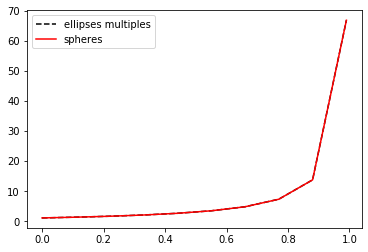

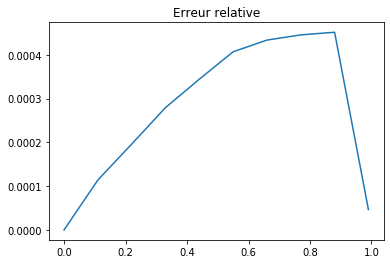

In [6]:
from classes2 import * 
Ef,Em = 100,1
nuf,num = 0.3,0.3
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,0.99,10)
LE1,LE2,LE3,LEr = [],[],[],[]

for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    
    E2,nu2 = Mori_tanaka_multiple(matrix_behavior,[(inclusion_behavior,f,ar)])
    E3 = Mori_Tanaka().compute_h_behavior(microstructure)['E']
    Er = (E2-E3)/E3
    
    
    LE2.append(E2)
    LE3.append(E3)
    LEr.append(Er)


plt.plot(F,LE2,'--k',label = "ellipses multiples")
plt.plot(F,LE3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F,LEr)
plt.title("Erreur relative")
plt.show()


### Faire tourner Cf dans A ou non 

In [11]:
def Mori_tanaka_multiple_oui(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            T = fm*Id
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) : 
                CfiR = Comp3333_to_66(Rotation_tenseur2(Comp66_to_3333(Cfi),Rotation_Op,j))
                AeshiR = inv(Id + np.matmul(Esh,np.matmul(Sm,CfiR-Cm)))
                T += fi_1_renfort*AeshiR
                V6i = np.matmul(CfiR,AeshiR)
                clear_matrix2(V6i)
                W += fi_1_renfort * V6i

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

def Mori_tanaka_multiple_non(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

In [12]:
from classes2 import *

Ef,Em = 100,1
nuf,num = 0.3,0.3
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,0.99,5)
LE1,LE2,LE3,LEr = [],[],[],[]

for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    
    print(Mori_tanaka_multiple_oui(matrix_behavior,[(inclusion_behavior,f,ar)]))
    print(Mori_tanaka_multiple_non(matrix_behavior,[(inclusion_behavior,f,ar)]))

f= 0.0
(1.0, 0.3)
(1.0, 0.3)
f= 0.2475
(1.6503156835817576, 0.2829428715746935)
(1.6501858659783435, 0.28292488400588506)
f= 0.495
(2.9093530386384288, 0.2705121820413434)
(2.909002494417406, 0.27048366192305906)
f= 0.7424999999999999
(6.405924578917924, 0.2620783540178645)
(6.404698986551487, 0.26203224002500136)
f= 0.99
(66.78420564326198, 0.28383844564490224)
(66.77137172754696, 0.2837981050473032)


### VERSION PROPRE : AUTOCOHERENT INCLUSIONS DE FORMES ET COMPORTEMENT DIFFERENTS

In [46]:
from scipy.spatial.transform import Rotation as Rot
        
def Autocoherent_multiple(Cm, inclusion_behaviors):
    # Paramètres internes du modèles         
    n_renforts = 1000     # paramètre non physique qui permet de forcer l'isotropie
    n_points_fixe = 90   # précise le pas de dilution (pour l'initialisation du point fixe)
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe

    Sm = Cm['S']
    Cm = Cm['C']
    Id = np.identity(6) 
    n_inclusions = len(inclusion_behaviors)
    
    ######### POUR LE TEST UNIQUEMENT #########
    f = inclusion_behaviors[0][1]
    LE = []
    F = []
    ###########################################

    #Création des matrices de rotations
    Rotation_Op = Rotation_operator(n_renforts)         

    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm

    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_points_fixe+1) :
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé

        convergence = 2

        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print(i," pas sur ",n_points_fixe,'en cours')
        print('convergence',convergence)
        while convergence>precision :   
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch

            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Cf = inclusion_behaviors[j][0]['C']
                a2,a3 = inclusion_behaviors[j][2]
                A = 1,a2,a3
                Esh = Eshelby_tensor(A,Eh,nuh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                V6 = np.dot(Cf-Cm,Aesh)
                V3 = Comp66_to_3333(V6)

                # Ajout des contribution de chaque renfort en fonction de son orientation
                for k in range(n_renforts) :                    
                    V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                    V = Comp3333_to_66(V3R)
                    W += inclusion_behaviors[j][1]*i/(n_points_fixe*n_renforts) * V
            Ch = Cm + W

            # Actualisation du matériau homogénéisé
            Cp = Ch

            # Test de sortie
            E = Young_isotropeC(Cp)
            nu = nu_isotropeC(Cp)
            convergence = abs(E-Eh)/Eh

            print('convergence',convergence)
            Eh = E
            nuh = nu           

            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            
        LE.append(Eh)
        F.append(f*i/n_points_fixe)

    return LE,F

0  pas sur  90 en cours
convergence 2
convergence 0.0
1  pas sur  90 en cours
convergence 2
convergence 0.01995457108480947
convergence 0.00038431917925001304
2  pas sur  90 en cours
convergence 2
convergence 0.019950918213412192
convergence 0.0007679828138999011
3  pas sur  90 en cours
convergence 2
convergence 0.019962028345938562
convergence 0.001151802541824819
4  pas sur  90 en cours
convergence 2
convergence 0.019987854474502267
convergence 0.0015365828770686702
5  pas sur  90 en cours
convergence 2
convergence 0.02002840998636799
convergence 0.0019231264817986195
6  pas sur  90 en cours
convergence 2
convergence 0.020083767830438255
convergence 0.0023122392890932626
7  pas sur  90 en cours
convergence 2
convergence 0.020154060237684967
convergence 0.002704735539543259
8  pas sur  90 en cours
convergence 2
convergence 0.02023947897009293
convergence 0.0031014427894806127
9  pas sur  90 en cours
convergence 2
convergence 0.02034027608042435
convergence 0.0035032069441548507
10  pa

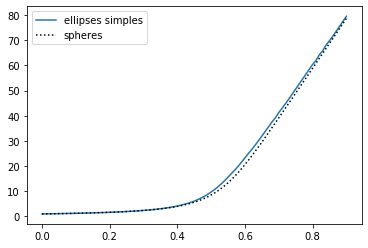

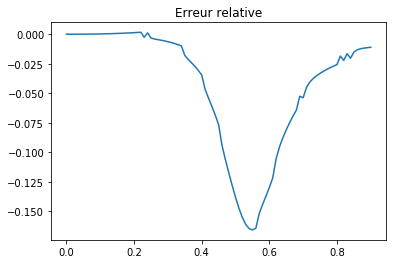

In [47]:
from classes_v2 import * 

Ef,Em = 100,1
nuf,num = 0.3,0.3
f = 0.9
ar = (1,1)

Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)
Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

EH,Fh = Autocoherent_multiple(matrix_behavior,[(inclusion_behavior,f,ar)])


inclusion = Inclusion(0,inclusion_behavior2)
LE1,LEr = [],[]

for i in range(len(Fh)) : 
    f = Fh[i]
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    E1 = Autocoherent_Hill().compute_h_behavior(microstructure)['E']
    Er = (E1-EH[i])/E1
    
    
    LE1.append(E1)
    LEr.append(Er)
    
plt.plot(Fh,EH,label = "ellipses simples")
plt.plot(Fh,LE1,':k',label = "spheres")
plt.legend()
plt.show()

plt.plot(Fh,LEr)
plt.title("Erreur relative")
plt.show()

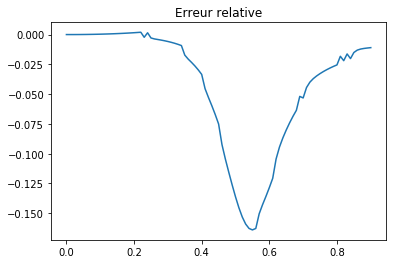

In [45]:
plt.plot(Fh,LEr)
plt.title("Erreur relative")
plt.show()

# Schema differentiel

In [61]:
def Differentiel(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch (f+df) = Ch(f) + Somme(dfi*dChi/dfi)  avec dChi/dfi = 1/fm * (Ci-Ch)*Aeshi avec Aeshi = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        n_pas = 10 
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        B = np.zeros((3,3,3,3))
        
        # Initialisation de la solution diluée : 
        Ch = Cm
        Sh = Sm
        for k in range (1,n_pas+1) : 
            dC = np.zeros((6,6))
            for i in range(len(inclusion_behaviors)) :   
                Sfi = inclusion_behaviors[i][0]['S']
                Cfi = inclusion_behaviors[i][0]['C']
                fi = inclusion_behaviors[i][1]*k/n_pas
                Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])

                fi_1_renfort = fi/n_renforts 

                Esh = Eshelby_tensor(Ai,Em,num)
                Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sh,Cfi-Ch)))
                #V6i = np.matmul(Cfi-Cm,Aeshi)
                #clear_matrix2(V6i)
                V6i = Cfi
                RCi = np.zeros((6,6)) # Matrice dérivee de l'evolution du comportement pour l'inclusion i
                # Ajout des contribution de chaque renfort en fonction de son orientation
            
                for j in range(n_renforts) :         
                    V3 = Comp66_to_3333(V6i)
                    V3R = Rotation_tenseur3(V3,Rotation_Op,j,B)
                    V = Comp3333_to_66(V3R)
                    RCi += fi_1_renfort * V
                dC += np.matmul(RCi-Ch,Aeshi)/fm
            Ch = Ch + dC
            Sh = inv(Ch)
            print(k," pas effectué sur ",n_pas)
            print('f = ',fi,' E = :',Young_isotropeC(Ch))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu
    
def Differentiel1(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch (f+df) = Ch(f) + Somme(dfi*dChi/dfi)  avec dChi/dfi = 1/fm * (Ci-Ch)*Aeshi avec Aeshi = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        n_pas = 10
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1 - inclusion_behaviors[1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        B = np.zeros((3,3,3,3))

        
        # Initialisation de la solution diluée : 
        Ch = Cm
        Sh = Sm
        
        Sfi = inclusion_behaviors[0]['S']
        Cfi = inclusion_behaviors[0]['C']     
        f = inclusion_behaviors[1]
        df = f/n_pas
        Ai = (1,inclusion_behaviors[2][0],inclusion_behaviors[2][0])
        Esh = Eshelby_tensor(Ai,Em,num)
        fi = 0
        
        
        for k in range (1,n_pas+1) : 
            fi+=df
            dCh = np.zeros((6,6))
            DC = Cfi - Ch
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sh,DC))) 
            
            # Ajout des contribution de chaque renfort en fonction de son orientation   
           
            DC3 = Comp66_to_3333(DC)
            DC3R= np.zeros((3,3,3,3))
            DC6= np.zeros((6,6))
            for j in range(n_renforts) : 
                DC3R += Rotation_tenseur3(DC3,Rotation_Op,i,B)
            DC6 = Comp3333_to_66(DC3R)
            RC = df/n_renforts/(1-fi) * DC6
            
            dCh = np.matmul(RC,Aeshi)
            Ch = Ch + dCh
            Sh = inv(Ch)
            #print(k," pas effectué sur ",n_pas)
            #print('f = ',fi,' E = :',Young_isotropeC(Ch))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu
    
    
def Differentiel2(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch (f+df) = Ch(f) + Somme(dfi*dChi/dfi)  avec dChi/dfi = 1/fm * (Ci-Ch)*Aeshi avec Aeshi = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 1     # paramètre non physique qui permet de forcer lisotropie
        n_pas = 100
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        B = np.zeros((3,3,3,3))

        
        # Initialisation de la solution diluée : 
        Ch = Cm
        Sh = Sm        
        
        # Calculs préléminaires :
        Esh = []
        df = []
        Cf = []
        for i in range (len(inclusion_behaviors)) :
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])     
            
            Esh.append(Eshelby_tensor(Ai,Em,num))
            df.append(fi/n_pas)
            Cf.append(Cfi)
        
        for k in range (1,n_pas+1) :             
            dCh = np.zeros((6,6))
            fm_pas = 1
            for i in range(len(inclusion_behaviors)) :
                DCi = Cf[i]-Ch
                Aeshi = inv(Id + np.matmul(Esh[i],np.matmul(Sh,DCi)))                
                fi_pas = df[i]*k
                fm_pas -= fi_pas
                # Ajout des contribution de chaque renfort en fonction de son orientation     
                DCi3 = Comp66_to_3333(DCi)
                DCi3R= np.zeros((3,3,3,3))
                for j in range(n_renforts) : 
                    DCi3R += Rotation_tenseur3(DCi3,Rotation_Op,i,B)
                DCi6 = Comp3333_to_66(DCi3R)
                RCi = df[i]/n_renforts * DCi6
                dCh += np.matmul(RCi,Aeshi)

            Ch = Ch + 1/fm_pas*dCh
            Sh = inv(Ch)
        #print(k," pas effectué sur ",n_pas)
        #print('f = ',fi,' E = :',Young_isotropeC(Ch))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu
    


f= 0.0
f= 0.08888888888888889
f= 0.17777777777777778
f= 0.26666666666666666
f= 0.35555555555555557
f= 0.4444444444444445
f= 0.5333333333333333
f= 0.6222222222222222
f= 0.7111111111111111
f= 0.8


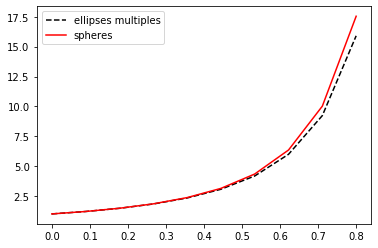

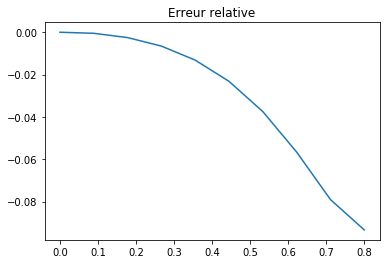

In [65]:
from classes2 import * 
Ef,Em = 100,1
nuf,num = 0.3,0.3
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,0.8,10)
LE1,LE2,LE3,LEr = [],[],[],[]

for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})

    E2,nu2 = Differentiel2(matrix_behavior,[[inclusion_behavior,f,ar]])
    E3 = Differential_Scheme().compute_h_behavior(microstructure)['E']
    Er = (E2-E3)/E3
    
    
    LE2.append(E2)
    LE3.append(E3)
    LEr.append(Er)


plt.plot(F,LE2,'--k',label = "ellipses multiples")
plt.plot(F,LE3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F,LEr)
plt.title("Erreur relative")
plt.show()


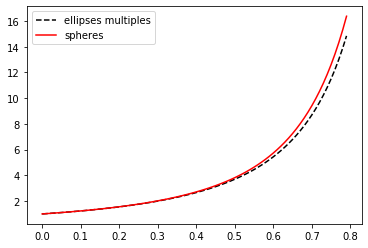

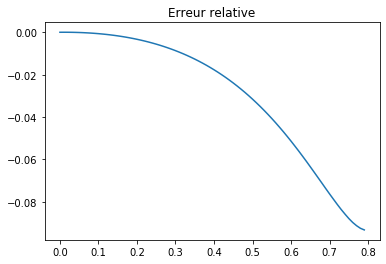

In [58]:
plt.plot(F[0:80],LE2[0:80],'--k',label = "ellipses multiples")
plt.plot(F[0:80],LE3[0:80],'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F[0:80],LEr[0:80])
plt.title("Erreur relative")
plt.show()